In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!curl https://colab.chainer.org/install |sh -
import cupy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   5663      0 --:--:-- --:--:-- --:--:--  5642
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9MB 86kB/s 
     |████████████████████████████████| 1.0MB 47.9MB/s 
+ set +ex
Installation succeeded!


### Deep Learning Barrier Option

We used Numba and CuPy in the previous notebook to run Monte Carlo simulation to determine the price of the Asian Barrier option. A Monte Carlo simulation needs millions of paths to get an accurate answer which is computationally intensive. [Ryan et al (2018)](https://arxiv.org/abs/1809.02233) showed that a deep learning model can be trained to value derivatives. The deep learning model is accurate and very fast, capable of producing valuations a million times faster than traditional models. In the this notebook, we will use a fully connected network to learn the pricing mode of the Asian Barrier option. Monte Carlo simulation is used as pricing ground truth for the training. We use the same Asian Barrier Option model as last notebook with parameters listed as following:

```
T - Maturity (yrs.)
S - Spot (usd)
K - Strike (usd)
sigma - Volatility (per.)
r - Risk Free Rate (per.)
mu - Stock Drift Rate (per.)
B - Barrier (usd)
```

### Batched Data generation

The dataset is an important part of the Deep learning training. We will modify the previous single Asian Barrier Option pricing code to handle a batch of Barrier Option pricing. 

Loading all the necessary libraries:-

In [ ]:
# !pip install cupy-cuda101

In [ ]:
# import cupy
# import numpy as np
# import math
# import time
# import torch
# cupy.cuda.set_allocator(None)
# from torch.utils.dlpack import from_dlpack

The CuPy version of batched barrier option pricing simulation is as follows:-

In [ ]:
# cupy_batched_barrier_option = cupy.RawKernel(r'''
# extern "C" __global__ void batched_barrier_option(
#     float *d_s,
#     const float T,
#     const float * K,
#     const float * B,
#     const float * S0,
#     const float * sigma,
#     const float * mu,
#     const float * r,
#     const float * d_normals,
#     const long N_STEPS,
#     const long N_PATHS,
#     const long N_BATCH)
# {
#   unsigned idx =  threadIdx.x + blockIdx.x * blockDim.x;
#   unsigned stride = blockDim.x * gridDim.x;
#   unsigned tid = threadIdx.x;
#   const float tmp3 = sqrt(T/N_STEPS);


#   for (unsigned i = idx; i<N_PATHS * N_BATCH; i+=stride)
#   {
#     int batch_id = i / N_PATHS;
#     int path_id = i % N_PATHS;
#     float s_curr = S0[batch_id];
#     float tmp1 = mu[batch_id]*T/N_STEPS;
#     float tmp2 = exp(-r[batch_id]*T);
#     unsigned n=0;
#     double running_average = 0.0;
#     for(unsigned n = 0; n < N_STEPS; n++){
#        s_curr += tmp1 * s_curr + sigma[batch_id]*s_curr*tmp3*d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH];
#        running_average += (s_curr - running_average) / (n + 1.0);
#        if (running_average <= B[batch_id]){
#            break;
#        }
#     }

#     float payoff = (running_average>K[batch_id] ? running_average-K[batch_id] : 0.f); 
#     d_s[i] = tmp2 * payoff;
#   }
# }

# ''', 'batched_barrier_option')

Note, the parameters (K, B, S0, sigma, mu, r) are passed in as an array with length of batch size. The output array is a two dimensional array flatten to 1-D. The first dimension is for Batch and the second dimension is for Path. 

Testing it out by entering two sets of option parameters:-

In [ ]:
# N_PATHS = 2048000
# N_STEPS = 365
# N_BATCH = 2
# T = 1.0

# K = cupy.array([110.0, 120.0], dtype=cupy.float32)
# B = cupy.array([100.0, 90.0], dtype=cupy.float32)
# S0 = cupy.array([120.0, 100.0], dtype=cupy.float32)
# sigma = cupy.array([0.35, 0.2], dtype=cupy.float32)
# mu = cupy.array([0.15, 0.1], dtype=cupy.float32)
# r =cupy.array([0.05, 0.05], dtype=cupy.float32)

Put everything into a simple function to launch this GPU kernel. The option prices for each batch is the average of the corresponding path terminal values. This can be computed easily by Cupy function `mean(axis=1)`

In [ ]:
# def batch_run():
#     number_of_threads = 256
#     number_of_blocks = (N_PATHS * N_BATCH - 1) // number_of_threads + 1
#     randoms_gpu = cupy.random.normal(0, 1, N_BATCH*N_PATHS * N_STEPS, dtype=cupy.float32)
#     output = cupy.zeros(N_BATCH*N_PATHS, dtype=cupy.float32)
#     cupy.cuda.stream.get_current_stream().synchronize()
#     s = time.time()
#     cupy_batched_barrier_option((number_of_blocks,), (number_of_threads,),
#                        (output, np.float32(T), K, B, S0, sigma, mu, r,
#                         randoms_gpu, N_STEPS, N_PATHS, N_BATCH))
#     v = output.reshape(N_BATCH, N_PATHS).mean(axis=1)
#     cupy.cuda.stream.get_current_stream().synchronize()
#     e = time.time()
#     print('time', e-s, 'v',v)
# batch_run()

This produces the option prices $21.22$ and $0.848$ for these two sets of option parameters in $66ms$.

It works efficiently hence we will construct an `OptionDataSet` class to wrap the above code so we can use it in Pytorch. For every `next` element, it generates uniform distributed random option parameters in the specified range, launches the GPU kernel to compute the option prices, convert the CuPy array to Pytorch tensors with zero copy via the DLPack. Note how we implemented the iterable Dataset interface:-

In [ ]:
# class OptionDataSet(torch.utils.data.IterableDataset):
    
#     def __init__(self, max_len=10, number_path = 1000, batch=2, threads=256,seed=15):
#         self.num = 0
#         self.max_length = max_len
#         self.N_PATHS = number_path
#         self.N_STEPS = 365
#         self.N_BATCH = batch
#         self.T = np.float32(1.0)
#         self.output = cupy.zeros(self.N_BATCH*self.N_PATHS, dtype=cupy.float32) 
#         self.number_of_blocks = (self.N_PATHS * self.N_BATCH - 1) // threads + 1
#         self.number_of_threads = threads
#         cupy.random.seed(seed)
        
#     def __len__(self):
#         return self.max_length
        
#     def __iter__(self):
#         self.num = 0
#         return self
    
#     def __next__(self):
#         if self.num > self.max_length:
#             raise StopIteration
#         X = cupy.random.rand(self.N_BATCH, 6, dtype=cupy.float32)
#         # scale the [0, 1) random numbers to the correct range for each of the option parameters
#         X = X * cupy.array([200.0, 0.99, 200.0, 0.4, 0.2, 0.2], dtype=cupy.float32)
#         # make sure the Barrier is smaller than the Strike price
#         X[:, 1] = X[:, 0] * X[:, 1]
#         randoms = cupy.random.normal(0, 1, self.N_BATCH * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
#         cupy_batched_barrier_option((self.number_of_blocks,), (self.number_of_threads,), (self.output, self.T, cupy.ascontiguousarray(X[:, 0]), 
#                               cupy.ascontiguousarray(X[:, 1]), cupy.ascontiguousarray(X[:, 2]), cupy.ascontiguousarray(X[:, 3]), cupy.ascontiguousarray(X[:, 4]), cupy.ascontiguousarray(X[:, 5]), randoms, self.N_STEPS, self.N_PATHS, self.N_BATCH))
#         Y = self.output.reshape(self.N_BATCH, self.N_PATHS).mean(axis=1)
#         self.num += 1
#         return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))

Put everything related to Pytorch dataset into a file `cupy_dataset.py`:-

In [ ]:
# #%%writefile cupy_dataset.py 
# import cupy
# import numpy as np
# import torch
# from torch.utils.dlpack import from_dlpack
# cupy.cuda.set_allocator(None)

# cupy_batched_barrier_option = cupy.RawKernel(r'''
# extern "C" __global__ void batched_barrier_option(
#     float *d_s,
#     const float T,
#     const float * K,
#     const float * B,
#     const float * S0,
#     const float * sigma,
#     const float * mu,
#     const float * r,
#     const float * d_normals,
#     const long N_STEPS,
#     const long N_PATHS,
#     const long N_BATCH)
# {
#   unsigned idx =  threadIdx.x + blockIdx.x * blockDim.x;
#   unsigned stride = blockDim.x * gridDim.x;
#   unsigned tid = threadIdx.x;
#   const float tmp3 = sqrt(T/N_STEPS);


#   for (unsigned i = idx; i<N_PATHS * N_BATCH; i+=stride)
#   {
#     int batch_id = i / N_PATHS;
#     int path_id = i % N_PATHS;
#     float s_curr = S0[batch_id];
#     float tmp1 = mu[batch_id]*T/N_STEPS;
#     float tmp2 = exp(-r[batch_id]*T);
#     unsigned n=0;
#     double running_average = 0.0;
#     for(unsigned n = 0; n < N_STEPS; n++){
#        s_curr += tmp1 * s_curr + sigma[batch_id]*s_curr*tmp3*d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH];
#        running_average += (s_curr - running_average) / (n + 1.0);
#        if (running_average <= B[batch_id]){
#            break;
#        }
#     }

#     float payoff = (running_average>K[batch_id] ? running_average-K[batch_id] : 0.f); 
#     d_s[i] = tmp2 * payoff;
#   }
# }

# ''', 'batched_barrier_option')

# class OptionDataSet(torch.utils.data.IterableDataset):
    
#     def __init__(self, max_len=10, number_path = 1000, batch=2, threads=256,seed=15):
#         self.num = 0
#         self.max_length = max_len
#         self.N_PATHS = number_path
#         self.N_STEPS = 365
#         self.N_BATCH = batch
#         self.T = np.float32(1.0)
#         self.output = cupy.zeros(self.N_BATCH*self.N_PATHS, dtype=cupy.float32) 
#         self.number_of_blocks = (self.N_PATHS * self.N_BATCH - 1) // threads + 1
#         self.number_of_threads = threads
#         cupy.random.seed(seed)
        
#     def __len__(self):
#         return self.max_length
        
#     def __iter__(self):
#         self.num = 0
#         return self
    
#     def __next__(self):
#         if self.num > self.max_length:
#             raise StopIteration
#         X = cupy.random.rand(self.N_BATCH, 6, dtype=cupy.float32)
#         # scale the [0, 1) random numbers to the correct range for each of the option parameters
#         X = X * cupy.array([200.0, 0.99, 200.0, 0.4, 0.2, 0.2], dtype=cupy.float32)
#         # make sure the Barrier is smaller than the Strike price
#         X[:, 1] = X[:, 0] * X[:, 1]
#         randoms = cupy.random.normal(0, 1, self.N_BATCH * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
#         cupy_batched_barrier_option((self.number_of_blocks,), (self.number_of_threads,), (self.output, self.T, cupy.ascontiguousarray(X[:, 0]), 
#                               cupy.ascontiguousarray(X[:, 1]), cupy.ascontiguousarray(X[:, 2]), cupy.ascontiguousarray(X[:, 3]), cupy.ascontiguousarray(X[:, 4]), cupy.ascontiguousarray(X[:, 5]), randoms, self.N_STEPS, self.N_PATHS, self.N_BATCH))
#         Y = self.output.reshape(self.N_BATCH, self.N_PATHS).mean(axis=1)
#         self.num += 1
#         return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))

Here is a test code to sample 10 data points with batch size 16:-

In [ ]:
# from cupy_dataset import OptionDataSet
# ds = OptionDataSet(10, number_path=100000, batch=16, seed=15)
# for i in ds:
#     print(i[1])

We can implement the same code by using Numba to accelerate the calculation in GPU:-

In [ ]:
# import numba
# from numba import cuda

# @cuda.jit
# def batch_barrier_option(d_s, T, K, B, S0, sigma, mu, r, d_normals, N_STEPS, N_PATHS, N_BATCH):
#     # ii - overall thread index
#     ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#     stride = cuda.gridDim.x * cuda.blockDim.x
#     tmp3 = math.sqrt(T/N_STEPS)
#     for i in range(ii, N_PATHS * N_BATCH, stride):
#         batch_id = i // N_PATHS
#         path_id = i % N_PATHS
#         tmp1 = mu[batch_id]*T/N_STEPS
#         tmp2 = math.exp(-r[batch_id]*T)
#         running_average = 0.0
#         s_curr = S0[batch_id]
#         for n in range(N_STEPS):

#             s_curr += tmp1 * s_curr + sigma[batch_id]*s_curr*tmp3*d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH]
#             running_average = running_average + 1.0/(n + 1.0) * (s_curr - running_average)
#             if i==0 and batch_id == 2:
#                 print(s_curr)
#             if running_average <= B[batch_id]:
#                 break
#         payoff = running_average - K[batch_id] if running_average > K[batch_id] else 0
#         d_s[i] = tmp2 * payoff

# class NumbaOptionDataSet(object):
    
#     def __init__(self, max_len=10, number_path = 1000, batch=2, threads=512, seed=15):
#         self.num = 0
#         self.max_length = max_len
#         self.N_PATHS = number_path
#         self.N_STEPS = 365
#         self.N_BATCH = batch
#         self.T = np.float32(1.0)
#         self.output = cupy.zeros(self.N_BATCH*self.N_PATHS, dtype=cupy.float32) 
#         self.number_of_blocks = (self.N_PATHS * self.N_BATCH - 1) // threads + 1
#         self.number_of_threads = threads
#         cupy.random.seed(seed)
        
#     def __len__(self):
#         return self.max_length

#     def __iter__(self):
#         self.num = 0
#         return self
    
#     def __next__(self):
#         if self.num > self.max_length:
#             raise StopIteration
#         X = cupy.random.rand(self.N_BATCH, 6, dtype=cupy.float32)
#         # scale the [0, 1) random numbers to the correct range for each of the option parameters
#         X = X * cupy.array([200.0, 0.99, 200.0, 0.4, 0.2, 0.2], dtype=cupy.float32)
#         # make sure the Barrier is smaller than the Strike price
#         X[:, 1] = X[:, 0] * X[:, 1]
#         randoms = cupy.random.normal(0, 1, self.N_BATCH * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
#         batch_barrier_option[(self.number_of_blocks,), (self.number_of_threads,)](self.output, self.T, X[:, 0], 
#                               X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], randoms, self.N_STEPS, self.N_PATHS, self.N_BATCH)
#         o = self.output.reshape(self.N_BATCH, self.N_PATHS)
#         Y = o.mean(axis = 1) 
#         self.num += 1
#         return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))
# ds = NumbaOptionDataSet(10, number_path=100000, batch=1, seed=15)
# for i in ds:
#     print(i[1])

tensor([165.6941], device='cuda:0')
tensor([51.4442], device='cuda:0')
tensor([31.0613], device='cuda:0')
tensor([21.1520], device='cuda:0')
tensor([32.8344], device='cuda:0')
tensor([21.4236], device='cuda:0')
tensor([0.], device='cuda:0')
tensor([22.7325], device='cuda:0')
tensor([0.0027], device='cuda:0')
tensor([66.4288], device='cuda:0')
tensor([39.2807], device='cuda:0')


# TEST_ERIN

In [ ]:
################################# TEST ########################################
%%writefile cupy_dataset.py

import numba
from numba import cuda
import random
import cupy
import numpy as np
import math
import time
import torch
cupy.cuda.set_allocator(None)
from torch.utils.dlpack import from_dlpack

@cuda.jit
def batch_barrier_option(d_s, T, K, B, S0, sigma, mu, r, d_normals, N_STEPS, N_PATHS, N_BATCH):
    # ii - overall thread index
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    stride = cuda.gridDim.x * cuda.blockDim.x
    tmp3 = math.sqrt(T/N_STEPS)
    for i in range(ii, N_PATHS * N_BATCH, stride):
        batch_id = i // N_PATHS
        path_id = i % N_PATHS
        tmp1 = mu[batch_id]*T/N_STEPS
        tmp2 = math.exp(-r[batch_id]*T)
        running_average = 0.0
        s_curr = S0[batch_id]
        for n in range(N_STEPS):
            s_curr += tmp1 * s_curr + sigma[batch_id]*s_curr*tmp3*d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH] # stock price
            running_average = running_average + 1.0/(n + 1.0) * (s_curr - running_average) # average of the path
            if i==0 and batch_id == 2:
                print(s_curr)
            if running_average <= B[batch_id]: # if reach barrier, drop out the path
                break
        payoff = running_average - K[batch_id] if running_average > K[batch_id] else 0
        d_s[i] = tmp2 * payoff

class NumbaOptionDataSet(object):
    
    def __init__(self, max_len=10, number_path = 1000, batch=2, threads=512, seed=15, stocks=3):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 365
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = np.float32(1.0)
        self.output = cupy.zeros(self.N_STOCKS*self.N_PATHS, dtype=cupy.float32) 
        self.number_of_blocks = (self.N_PATHS * self.N_STOCKS - 1) // threads + 1
        self.number_of_threads = threads
        cupy.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num > self.max_length:
            raise StopIteration
        
        Y = cupy.zeros(self.N_BATCH, dtype=cupy.float32)
        paras = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)
        for op in range(self.N_BATCH):
          # X = cupy.random.rand(self.N_STOCKS, 6, dtype=cupy.float32)
          X = cupy.array([200.0, 0.99, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32).reshape(self.N_STOCKS, 6)
          # scale the [0, 1) random numbers to the correct range for each of the option parameters
          # X = X * cupy.array([200.0, 0.99, 200.0, 0.4, 0.2, 0.2], dtype=cupy.float32) # parameters
          # make sure the Barrier is smaller than the Strike price
          # X[:, 1] = X[:, 0] * X[:, 1]
          for i in range(self.N_STOCKS):
            paras[op,i*6:(i+1)*6] = X[i,:]

          stocks_randoms_mean = cupy.zeros(self.N_STOCKS, dtype = cupy.float32)
          rho = cupy.random.normal(0, 1, self.N_STOCKS, dtype = cupy.float32)
          #stocks_randoms_cov = cupy.ones((self.N_STOCKS, self.N_STOCKS), dtype = cupy.float32)
          #cupy.fill_diagonal(stocks_randoms_cov, rho)
          stocks_randoms_cov = (-0.99 + cupy.random.rand(self.N_STOCKS*self.N_STOCKS, dtype=cupy.float32)*2*0.99).reshape(self.N_STOCKS,self.N_STOCKS)
          cupy.fill_diagonal(stocks_randoms_cov, 1)
          num_of_randoms_each_stock = self.N_PATHS * self.N_STEPS
          randoms_gpu = cupy.random.multivariate_normal(stocks_randoms_mean, stocks_randoms_cov,
                                                        num_of_randoms_each_stock, dtype=cupy.float32)
          b1_r = randoms_gpu[:,0]
          b2_r = randoms_gpu[:,1]
          randoms = cupy.zeros(self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
          interval = int((self.N_PATHS * self.N_STEPS * self.N_STOCKS) / self.N_PATHS)
          for i in range(interval):
            if i % 2 == 0:
                ind = int(i/2)
                randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b1_r[ind:(ind+self.N_PATHS)]
            else:
                ind = int(i//2)
                randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b2_r[ind:(ind+self.N_PATHS)]

          randoms = cupy.random.normal(0, 1, self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
          batch_barrier_option[(self.number_of_blocks,), (self.number_of_threads,)](self.output, self.T, X[:, 0], 
                                X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], randoms, self.N_STEPS, self.N_PATHS, self.N_STOCKS)
          
          o = self.output.reshape(self.N_STOCKS, self.N_PATHS)
          Y[op] = o.mean(axis = 0).mean()

        self.num += 1
        return (from_dlpack(paras.toDlpack()), from_dlpack(Y.toDlpack()))



# ds = NumbaOptionDataSet(10, number_path=100000, batch=3, seed=random.randint(0,100), stocks=5)
# for i in ds:
#     print(i[1])
################################# TEST ########################################

Writing cupy_dataset.py


### PUI TEST

In [ ]:
# %%writefile cupy_dataset.py
# import numba
# from numba import cuda
# import cupy
# import numpy as np
# import math
# import time
# import torch
# cupy.cuda.set_allocator(None)
# from torch.utils.dlpack import from_dlpack

# @cuda.jit
# def single_barrier_option(d_s, T, K, B, S0, sigma, mu, r, d_normals, N_STEPS, N_PATHS, N_STOCKS, s_curr):

#     # ii - overall thread index
#     ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#     stride = cuda.gridDim.x * cuda.blockDim.x
#     tmp2 = math.exp(-r*T)
#     tmp3 = math.sqrt(T/N_STEPS)    

#     for i in range(ii, N_PATHS, stride): # for each path          
#         running_average = 0.0

#         for j in range(N_STOCKS): # initialize S0
#             s_curr[j] = S0[j]

#         for n in range(N_STEPS): # for each step
#             s_curr_avg = 0.0

#             for j in range(N_STOCKS): # for each stock
#                 tmp1 = mu[j]*T/N_STEPS  
#                 s_curr[j] += tmp1 * s_curr[j] + sigma[j]*s_curr[j]*tmp3*d_normals[i,n,j]
#                 s_curr_avg = s_curr_avg + 1.0/(j + 1.0) * (s_curr[j] - s_curr_avg) # S average in this step

#             # add stock average to running average
#             running_average = running_average + 1.0/(n + 1.0) * (s_curr_avg - running_average)

#             # compare to barrier
#             if running_average <= B:
#                 break

#         payoff = running_average - K if running_average > K else 0
#         d_s[i] = tmp2 * payoff
    

# class NumbaOptionDataSet(object):
    
#     def __init__(self, max_len=10, number_path = 1000, number_stocks = 3, batch=1, threads=512, seed=15, T=1):
#         self.num = 0
#         self.max_length = max_len
#         self.N_PATHS = number_path
#         self.N_STEPS = 365
#         self.N_STOCKS = number_stocks
#         self.N_BATCH = batch
#         self.T = np.float32(T)
#         self.output = cupy.zeros(self.N_PATHS, dtype=cupy.float32) 
#         self.number_of_blocks = (self.N_PATHS * self.N_STOCKS - 1) // threads + 1
#         self.number_of_threads = threads
#         cupy.random.seed(seed)

#         ############ <new
#         self.Z_mean = cupy.zeros(self.N_STOCKS, dtype=cupy.float32)
#         self.Z_cov = (-0.2 + cupy.random.rand(self.N_STOCKS*self.N_STOCKS, dtype=cupy.float32)*0.4).reshape(self.N_STOCKS,self.N_STOCKS)
#         cupy.fill_diagonal(self.Z_cov, 1)
#         ############ new>

#     def __len__(self):
#         return self.max_length
        
#     def __iter__(self):
#         self.num = 0
#         return self
    
#     def __next__(self):
#         if self.num > self.max_length:
#             raise StopIteration

#         X = cupy.zeros((self.N_BATCH, 3 + self.N_STOCKS * 3), dtype=cupy.float32)
#         Y = cupy.zeros(self.N_BATCH, dtype=cupy.float32)

#         for i in range(self.N_BATCH): # for each batch
#           self.S0 = cupy.random.rand(self.N_STOCKS, dtype=cupy.float32) * 200
#           self.K = 110.0
#           self.B = 100.0
#           self.sigma = cupy.random.rand(self.N_STOCKS, dtype=cupy.float32) * 0.2
#           self.mu = cupy.random.rand(self.N_STOCKS, dtype=cupy.float32) * 0.2
#           self.r = 0.05
#           self.s_curr = cupy.zeros(self.N_STOCKS, dtype=cupy.float32) # used to store s_curr in kernel

#           ############ <new - add correlation between stocks
#           all_normals = cupy.random.multivariate_normal(self.Z_mean, self.Z_cov, (self.N_PATHS, self.N_STEPS), dtype=cupy.float32)
#           ############ new>
          
#           single_barrier_option[(self.number_of_blocks,), (self.number_of_threads,)](self.output, self.T, self.K, self.B, self.S0, 
#                                                                                     self.sigma, self.mu, self.r, all_normals, self.N_STEPS, self.N_PATHS, self.N_STOCKS, self.s_curr)
#           Y[i] = self.output.mean()

#           ############ <new - combine to get X matrix
#           X[i,:] = cupy.array([self.K, self.B] + self.S0.tolist() +
#                                 self.sigma.tolist() + self.mu.tolist() + [self.r], dtype=cupy.float32)
#           ############ new>
        
#         self.num += 1
#         return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))

# ds = NumbaOptionDataSet(max_len=10, number_path=100, batch=2, seed=15)
# for i in ds:
#   print(i)

### Model
To map the option parameters to price, we use 6 layers of fully connected neural network with hidden dimension 512 as inspired by [this paper](https://arxiv.org/abs/1809.02233). Writing this DL price model into a file `model.py`:-

In [ ]:
# %%writefile model.py
# import torch.nn as nn
# import torch.nn.functional as F
# import torch


# class Net(nn.Module):

#     def __init__(self, hidden=1024):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(6, hidden)
#         self.fc2 = nn.Linear(hidden, hidden)
#         self.fc3 = nn.Linear(hidden, hidden)
#         self.fc4 = nn.Linear(hidden, hidden)
#         self.fc5 = nn.Linear(hidden, hidden)
#         self.fc6 = nn.Linear(hidden, 1)
#         self.register_buffer('norm',
#                              torch.tensor([200.0,
#                                            198.0,
#                                            200.0,
#                                            0.4,
#                                            0.2,
#                                            0.2,]))

#     def forward(self, x):
#         # normalize the parameter to range [0-1] 
#         x = x / self.norm
#         x = F.elu(self.fc1(x))
#         x = F.elu(self.fc2(x))
#         x = F.elu(self.fc3(x))
#         x = F.elu(self.fc4(x))
#         x = F.elu(self.fc5(x))
#         return self.fc6(x)

### Modified Model

In [ ]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np


class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(18, hidden) # remember to change this!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1)
        self.register_buffer('norm',
                             torch.tensor([200.0, 198.0, 200.0, 0.4, 0.2, 0.2,
                                           200.0, 198.0, 200.0, 0.4, 0.2, 0.2,
                                           200.0, 198.0, 200.0, 0.4, 0.2, 0.2])) # don't use numpy here - will give error later

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Overwriting model.py


As we know the random parameters' scaling factors, the input parameters are first scaled back to a range of (0-1) by dividing them by (200.0, 198.0, 200.0, 0.4, 0.2, 0.2). Then they are projected 5 times to the hidden dimension of 512 after the `ELu` activation function. `ELu` is chosen because we need to compute the second order differentiation of the parameters. If use ReLu, the second order differentiation will always be zero. The last layer is a linear layer that maps the hidden dimension to the predicted option price. 

For training, we use [Ignite](https://github.com/pytorch/ignite) which is a high-level library to train neural networks in PyTorch. We use `MSELoss` as the loss function, `Adam` as the optimizer and `CosineAnnealingScheduler` as the learning rate scheduler. The following code is feeding the random option data to the pricing model to train it.

### Train

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 225kB 8.8MB/s 


In [ ]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import NumbaOptionDataSet
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = NumbaOptionDataSet(max_len=10000, number_path = 1024, batch=4800)
dataset = NumbaOptionDataSet(max_len=100, number_path = 1024, batch=2, stocks=3)

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    loss = loss_fn(y_pred[:,0], y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 100

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value())
        
trainer.run(dataset, max_epochs=100)

loss 0.0038585129659622908 average time 0.05689646920001678
loss 0.0017782573122531176 average time 0.00486341141000139
loss 0.20000244677066803 average time 0.004686843499994211
loss 0.5028747320175171 average time 0.004823656369997025
loss 0.24546341598033905 average time 0.004941243999999187
loss 0.2537771761417389 average time 0.004796870490008587
loss 0.6996762752532959 average time 0.004677115920003416
loss 0.11817583441734314 average time 0.004744044249998751
loss 0.05672599747776985 average time 0.00476704006999853
loss 0.2679877281188965 average time 0.004743635239990453
loss 0.024315420538187027 average time 0.004603567749991271
loss 0.9470547437667847 average time 0.00470041277999826
loss 0.6844637989997864 average time 0.004733355819996632
loss 0.10903322696685791 average time 0.00478906875002167
loss 0.23783883452415466 average time 0.0046038681500022
loss 0.0571712888777256 average time 0.004739948049998475
loss 0.38784685730934143 average time 0.004668669330001194
loss 0

State:
	iteration: 10000
	epoch: 100
	epoch_length: 100
	max_epochs: 100
	output: 0.08833403885364532
	batch: <class 'tuple'>
	metrics: <class 'dict'>
	dataloader: <class 'cupy_dataset.NumbaOptionDataSet'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

The loss is keeping decreasing which means the pricing model can predict the option prices better. It takes about $12ms$ to compute one mini-batch in average, In the following sections, we will try to expore the full potentials of the GPU to accelerate the training.

### Inference and Greeks

We can load the model parameters and use it to do inference

In [ ]:
import torch
inputs = torch.tensor([[110.0, 100.0, 120.0, 0.35, 0.1, 0.05,
                                           110.0, 100.0, 120.0, 0.35, 0.1, 0.05,
                                           110.0, 100.0, 120.0, 0.35, 0.1, 0.05]]).cuda()
model(inputs.float())

tensor([[26.0681]], device='cuda:0', grad_fn=<AddmmBackward>)

One of the benefits of building a deep learning model is that the [Greeks](<https://en.wikipedia.org/wiki/Greeks_(finance)#First-order_Greeks>) can be easily computed. 
We just need to take advantage of the auto-grad feature in Pytorch. We can use `grad` function to compute the first order differentiation for parameters 'K, B, S0, sigma, mu, r'

In [ ]:
inputs = torch.tensor([[110.0, 100.0, 120.0, 0.35, 0.1, 0.05,
                                           110.0, 100.0, 120.0, 0.35, 0.1, 0.05,
                                           110.0, 100.0, 120.0, 0.35, 0.1, 0.05]]).cuda()
inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient

tensor([[ 3.5394e-04, -1.0371e-04,  4.8766e-04,  1.1956e-01,  3.9489e-01,
          3.5838e-01,  3.6811e-04, -7.6997e-05,  3.6901e-04,  1.4604e-01,
          4.2417e-01,  3.9377e-01,  3.8934e-04,  6.0267e-06,  4.0937e-04,
          1.7997e-01,  3.2281e-01,  4.1249e-01]], device='cuda:0')

Here we are going to plot the Delta graph:-

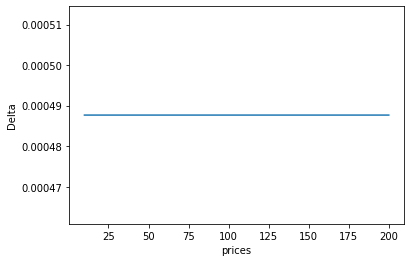

In [ ]:
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np
def compute_delta(S):
    inputs = torch.tensor([[110.0, 100.0, 120.0, 0.35, 0.1, 0.05,
                                           110.0, 100.0, 120.0, 0.35, 0.1, 0.05,
                                           110.0, 100.0, 120.0, 0.35, 0.1, 0.05]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]
prices = np.arange(10, 200, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

Calculating the second order derivative is easy in PyTorch too. We just need to apply the `grad` function twice. Use this mechanism, we can calculate the second order derivatives $\frac{\partial^2 P}{\partial K \partial S_0}$, $\frac{\partial^2 P}{\partial B \partial S_0}$, $\frac{\partial^2 P}{\partial S_0^2}$, $\frac{\partial^2 P}{\partial \sigma \partial S_0}$, $\frac{\partial^2 P}{\partial \mu \partial S_0}$, $\frac{\partial^2 P}{\partial r \partial S_0}$ in the following example.

In [ ]:
import torch
from torch import Tensor
from torch.autograd import Variable
from torch.autograd import grad
from torch import nn

inputs = torch.tensor([[110.0, 100.0, 120.0, 0.35, 0.1, 0.05,
                                           110.0, 100.0, 120.0, 0.35, 0.1, 0.05,
                                           110.0, 100.0, 120.0, 0.35, 0.1, 0.05]]).cuda()
inputs.requires_grad = True
x = model(inputs)

# instead of using loss.backward(), use torch.autograd.grad() to compute gradients
# https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
loss_grads = grad(x, inputs, create_graph=True)
drv = grad(loss_grads[0][0][2], inputs)
drv

(tensor([[-6.5058e-07,  2.0320e-07, -1.2868e-06, -2.2664e-04, -7.3022e-04,
          -6.6320e-04, -6.7666e-07,  1.7641e-07, -6.7138e-07, -2.5476e-04,
          -7.4334e-04, -7.2711e-04, -7.3867e-07, -1.4147e-08, -7.3973e-07,
          -3.5808e-04, -6.3159e-04, -7.4822e-04]], device='cuda:0'),)

Gamma is the second order differenation of `S`. We can plot the the Gamma curve as a function of the stock price

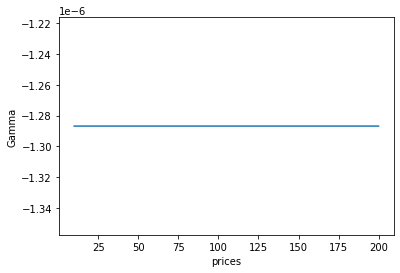

In [ ]:
import pylab
import numpy as np
def compute_gamma(S):
    inputs = torch.tensor([[110.0, 100.0, 120.0, 0.35, 0.1, 0.05,
                                           110.0, 100.0, 120.0, 0.35, 0.1, 0.05,
                                           110.0, 100.0, 120.0, 0.35, 0.1, 0.05]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    loss_grads = grad(x, inputs, create_graph=True)
    drv = grad(loss_grads[0][0][2], inputs)
    return drv[0][0][2]

prices = np.arange(10, 200, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_gamma(p).item())
fig2 = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Gamma')
fig2

[Implied volatility](https://en.wikipedia.org/wiki/Implied_volatility) is the forecasted volatility of the underlying asset based on the quoted prices of the option. It is the reverse mapping of price to the option parameter given the model which is hard to do with the Monte Carlo simulation approach. But if we have the deep learning pricing model, it is an easy task. We can first plot the relationship between volatility and the option price

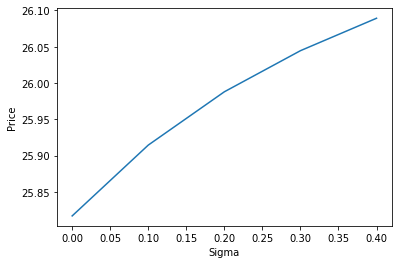

In [ ]:
import pylab
import numpy as np
def compute_price(sigma):
    inputs = torch.tensor([[110.0, 100.0, 120.0, sigma, 0.1, 0.05,
                                           110.0, 100.0, 120.0, sigma, 0.1, 0.05,
                                           110.0, 100.0, 120.0, sigma, 0.1, 0.05]]).cuda()
    x = model(inputs.float())
    #x = model(inputs)
    return x.item()
sigmas = np.arange(0, 0.5, 0.1)
prices = []
for s in sigmas:
    prices.append(compute_price(s))
fig3 = pylab.plot(sigmas, prices)
pylab.xlabel('Sigma')
pylab.ylabel('Price')
fig3

Given the prices `P`, the implied volatility is the root of the function `compute_price`. We can use bisection to find the root.

In [ ]:
def bisection_root(small, large, fun, target, EPS=1e-6):
    if fun(large) - target < 0:
        print('upper bound is too small')
        return None
    if fun(small) - target > 0:
        print('lower bound is too large')
        return None
    while large - small > EPS:
        mid = (large + small) / 2.0
        if fun(mid) - target >= 0:
            large = mid
        else:
            small = mid
    mid = (large + small) / 2.0
    return mid, abs(fun(mid) - target)
quoted_price = 16.0
sigma, err = bisection_root(0, 0.5, compute_price, quoted_price)
print('implied volativity', sigma, 'error', err)     

lower bound is too large


TypeError: ignored